In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading the spatial tessellation
Taking the shapefile of the 155 [urban areas](https://it.wikipedia.org/wiki/Zone_urbanistiche_di_Roma).

In [2]:
PATH_TO_DATA = '../data/external/ISTAT_zone_urbanistiche_Roma/'

gdf_rome = gpd.read_file(PATH_TO_DATA + 'Roma_Zone_Urbanistiche_WGS84.shp')
print(gdf_rome.shape)
print(gdf_rome.crs)
gdf_rome.head()

(155, 6)
epsg:32632


,PRO_COM,COD_Z_URB,DEN_Z_URB,SHAPE_Leng,SHAPE_Area,geometry
0,58091.0,10l,Morena,22732.760455,8.947226e+06,"POLYGON ((799657.107 4638085.920, 800364.229 4..."
1,58091.0,10a,Don Bosco,8400.069997,2.256348e+06,"POLYGON ((794872.968 4641012.637, 794889.887 4..."
2,58091.0,10b,Appio-Claudio,9265.317994,3.454590e+06,"POLYGON ((794285.305 4640821.527, 794303.261 4..."
3,58091.0,10c,Quarto Miglio,11017.098179,5.030157e+06,"POLYGON ((796561.107 4637688.499, 796576.519 4..."
4,58091.0,10d,Pignatelli,5161.962256,9.972986e+05,"POLYGON ((794842.436 4638845.513, 794843.764 4..."


In [3]:
# CODZU is a unique ID of each urban area
len(gdf_rome.COD_Z_URB)

# note: the total area of each zone ('SHAPE_Area') is in m^2

155

In [4]:
gdf_rome.COD_Z_URB = [cod.upper() for cod in gdf_rome.COD_Z_URB]

## Covariates

### Point-features
These are features like:
- traffic lights
- POIs

from which we will compute a measure of density for each of the urban areas.

#### Traffic lights

In [5]:
URL_TO_DATA = 'https://www.comune.roma.it/TERRITORIO/geoserver/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=dit:Semafori&SRSNAME=EPSG:6708&outputFormat=SHAPE-ZIP'

gdf_tl = gpd.read_file(URL_TO_DATA)
print(gdf_tl.shape)
print(gdf_tl.crs)
gdf_tl.head()

(1541, 9)
epsg:6708


,COD_IMP,TIPO,VIA_1,CIV,VIA_2,VIA_3,CIRC,SISTEMA_1,geometry
0,03036,V,Via Catania,None,Via Pavia,Via Cremona,II,Tmacs,POINT (294246.969 4642743.354)
1,03017,V,Viale Regina Margherita,None,Via Giovanni Battista Morgagni,None,II,Tmacs,POINT (293526.621 4642757.220)
2,03069,CL,Via della Stazione Tiburtina,None,Via G. Mazzoni,None,II,None,POINT (295076.397 4642760.961)
3,17058,APL,Via Cipro,None,P.le degli Eroi,Ospedale Oftalmico,I,None,POINT (288360.167 4642762.393)
4,17025,V,Viale Giulio Cesare,None,Via Candia,Via Leone IV,I,Sigma Plus,POINT (288962.732 4642769.784)


In [6]:
# reprojecting onto epsg:32633
gdf_tl_proj = gdf_tl.to_crs(gdf_rome.crs)

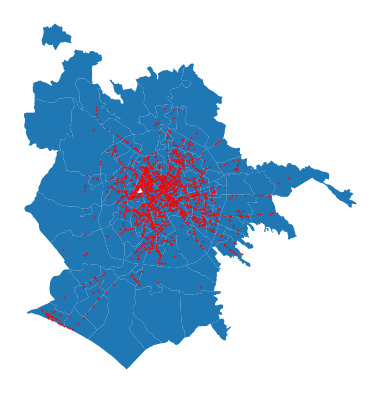

In [7]:
ax = gdf_rome.plot(figsize=(7,7))
gdf_tl_proj.plot(ax=ax, color='red', markersize=0.8)
ax.set_axis_off()

In [8]:
gdf_tl_join = gpd.sjoin(gdf_tl_proj, gdf_rome, how="inner", op='intersects')
print(gdf_tl_join.shape)
gdf_tl_join.head()

(1539, 15)


/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,COD_IMP,TIPO,VIA_1,CIV,VIA_2,VIA_3,CIRC,SISTEMA_1,geometry,index_right,PRO_COM,COD_Z_URB,DEN_Z_URB,SHAPE_Leng,SHAPE_Area
0,03036,V,Via Catania,None,Via Pavia,Via Cremona,II,Tmacs,POINT (791880.520 4645758.471),106,58091.0,3A,Nomentano,9426.788621,2.930423e+06
1,03017,V,Viale Regina Margherita,None,Via Giovanni Battista Morgagni,None,II,Tmacs,POINT (791160.589 4645721.909),106,58091.0,3A,Nomentano,9426.788621,2.930423e+06
2,03069,CL,Via della Stazione Tiburtina,None,Via G. Mazzoni,None,II,None,POINT (792707.126 4645834.077),106,58091.0,3A,Nomentano,9426.788621,2.930423e+06
74,03004,V,Via Nomentana,None,Viale Pola,Via Bosio,II,Omnia,POINT (791337.359 4646555.570),106,58091.0,3A,Nomentano,9426.788621,2.930423e+06
82,03064,CL,Circonvallazione Nomentana,328,Via Salento,Tang. Est direzione Foro Italico,II,None,POINT (792483.729 4646697.475),106,58091.0,3A,Nomentano,9426.788621,2.930423e+06


In [9]:
tl_number = gdf_tl_join['COD_Z_URB'].value_counts().reset_index()
tl_number.columns = ['COD_Z_URB', 'n_traffic_lights']

gdf_rome = gdf_rome.merge(tl_number, how='left', on='COD_Z_URB')
print(gdf_rome.shape)
gdf_rome.head()

(155, 7)


,PRO_COM,COD_Z_URB,DEN_Z_URB,SHAPE_Leng,SHAPE_Area,geometry,n_traffic_lights
0,58091.0,10L,Morena,22732.760455,8.947226e+06,"POLYGON ((799657.107 4638085.920, 800364.229 4...",10.0
1,58091.0,10A,Don Bosco,8400.069997,2.256348e+06,"POLYGON ((794872.968 4641012.637, 794889.887 4...",17.0
2,58091.0,10B,Appio-Claudio,9265.317994,3.454590e+06,"POLYGON ((794285.305 4640821.527, 794303.261 4...",16.0
3,58091.0,10C,Quarto Miglio,11017.098179,5.030157e+06,"POLYGON ((796561.107 4637688.499, 796576.519 4...",9.0
4,58091.0,10D,Pignatelli,5161.962256,9.972986e+05,"POLYGON ((794842.436 4638845.513, 794843.764 4...",2.0


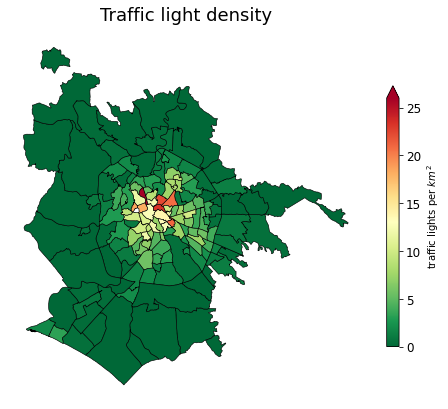

In [10]:
# NaNs are areas where there are zero traffic lights
gdf_rome['n_traffic_lights'] = gdf_rome['n_traffic_lights'].fillna(0)

# compute traffic light density for each area:
gdf_rome['density_traffic_lights'] = gdf_rome['n_traffic_lights'] / (gdf_rome['SHAPE_Area']*1e-6)

fig, ax = plt.subplots(1, figsize=(8,8))
gdf_rome.plot(ax=ax, column='density_traffic_lights', cmap='RdYlGn_r', edgecolor='black', linewidth=0.6,
              legend=True, legend_kwds={'label': r"traffic lights per $km^2$", 
                                        'orientation': "vertical", 
                                        'shrink':0.6, 'extend':'max'})
cbar = ax.get_figure().get_axes()[1]
cbar.tick_params(labelsize=12)

ax.set_title('Traffic light density', fontsize=18, pad=10)
ax.set_axis_off()

#fig = ax.get_figure()
#fig.savefig('rome_traffic_light_density.png', dpi=300)

#### Shops

The original .csv can be found at https://dati.comune.roma.it/catalog/dataset/d148/resource/da49d933-c541-4466-920e-2cc24aec0258.

We identified, when possible, the location of each shop from its address, and added it to the .csv as two new columns _lat, lng_. Here we load and use this last new file.

In [11]:
URL_TO_DATA = 'https://www.dropbox.com/s/8yyv0idtca3t8cj/rome_shops_with_location.csv?dl=1'

df_sh = pd.read_csv(URL_TO_DATA)
print(df_sh.shape)
df_sh.head()

(130244, 18)


,NUMEROESERCIZIO,DATAINIZIO,CODICEVIA,DESCRIZIONEVIA,CIVICO,ESPCIVICO,MUNICIPIO,SUPERFICIETOTALE,CODICEMACROATTIVITA,DESCRIZIONEMACROATTIVITA,TIPOATTIVITA,DESCRIZIONEATTIVITA,CODICESPECIALIZZAZIONE,DESCRIZIONESPECIALIZZAZIONE,SUPERFICIEALIMENTARE,SUPERFICIENONALIMENTARE,lat,lng
0,957,20020328,31130.0,VIA DEI CORONARI,37.0,NaN,MUN. I,45,CSF,COMMERCIO IN SEDE FISSA,100,Esercizio di Vicinato,36.0,"MOBILI, CASALINGHI E ARTICOLI DI ILLUMINAZIONE",NaN,NON_ALIMENTARE,41.900459,12.470566
1,956,20020314,16160.0,VIA DEL BOSCHETTO,46.0,NaN,MUN. I,NaN,CSF,COMMERCIO IN SEDE FISSA,100,Esercizio di Vicinato,21.0,"ARTICOLI DI SECONDA MANO (LIBRI, MOBILI, INDUM...",NaN,NON_ALIMENTARE,41.897572,12.490340
2,959,20020228,99862.0,VIA DELLA VII COORTE,5.0,NaN,MUN. I,NaN,CSF,COMMERCIO IN SEDE FISSA,100,Esercizio di Vicinato,3.0,"BEVANDE (VINI, OLI BIRRA E ALTRE)",ALIMENTARE,NaN,41.888709,12.474520
3,961,20020409,56364.0,VIA GIUSEPPE ROMITA,4.0,NaN,MUN. I,NaN,CSF,COMMERCIO IN SEDE FISSA,100,Esercizio di Vicinato,27.0,DISTRIBUTORI DI CARBURANTI,NaN,NON_ALIMENTARE,41.903308,12.496302
4,962,20020415,14311.0,VIA BELSIANA,4.0,NaN,MUN. I,NaN,CSF,COMMERCIO IN SEDE FISSA,100,Esercizio di Vicinato,36.0,"MOBILI, CASALINGHI E ARTICOLI DI ILLUMINAZIONE",NaN,NON_ALIMENTARE,41.905523,12.479411


In [12]:
# dropping one row with a completely wrong location (lng = -75.592625)
df_sh.drop(79789, axis=0, inplace=True)

In [13]:
n_shops_no_loc = len(df_sh[(df_sh.lat.isnull()==True) & (df_sh.lng.isnull()==True)])

print('There are %s shops with no identified location (%.1f%%).' %(n_shops_no_loc, n_shops_no_loc/len(df_sh)*100))

There are 801 shops with no identified location (0.6%).


In [14]:
# creating the gdf
gdf_sh = gpd.GeoDataFrame(df_sh, geometry=gpd.points_from_xy(df_sh.lng, df_sh.lat), crs='epsg:4326')

# reprojecting onto epsg:32633
gdf_sh_proj = gdf_sh.to_crs(gdf_rome.crs)

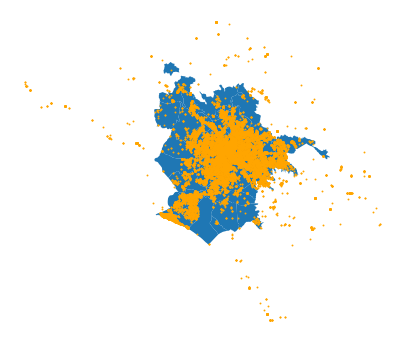

In [15]:
ax = gdf_rome.plot(figsize=(7,7))
gdf_sh_proj.plot(ax=ax, color='orange', markersize=0.8)
ax.set_axis_off()

In [16]:
# taking only the shops inside Rome
gdf_sh_join = gpd.sjoin(gdf_sh_proj, gdf_rome, how="inner", op='intersects')
print(gdf_sh_join.shape)
gdf_sh_join.head()

/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


(127868, 27)


,NUMEROESERCIZIO,DATAINIZIO,CODICEVIA,DESCRIZIONEVIA,CIVICO,ESPCIVICO,MUNICIPIO,SUPERFICIETOTALE,CODICEMACROATTIVITA,DESCRIZIONEMACROATTIVITA,...,lng,geometry,index_right,PRO_COM,COD_Z_URB,DEN_Z_URB,SHAPE_Leng,SHAPE_Area,n_traffic_lights,density_traffic_lights
0,957,20020328,31130.0,VIA DEI CORONARI,37.0,NaN,MUN. I,45,CSF,COMMERCIO IN SEDE FISSA,...,12.470566,POINT (787890.821 4644551.237),75,58091.0,1A,Centro Storico,9484.910322,3.204813e+06,41.0,12.793257
4,962,20020415,14311.0,VIA BELSIANA,4.0,NaN,MUN. I,NaN,CSF,COMMERCIO IN SEDE FISSA,...,12.479411,POINT (788601.757 4645143.271),75,58091.0,1A,Centro Storico,9484.910322,3.204813e+06,41.0,12.793257
7,965,20020221,68750.0,VIA MARGUTTA,1.0,B,MUN. I,31,CSF,COMMERCIO IN SEDE FISSA,...,12.478311,POINT (788491.416 4645610.761),75,58091.0,1A,Centro Storico,9484.910322,3.204813e+06,41.0,12.793257
19,991,20030515,111001.0,VIA DEL VANTAGGIO,41.0,A,MUN. I,24,CSF,COMMERCIO IN SEDE FISSA,...,12.476470,POINT (788344.232 4645468.905),75,58091.0,1A,Centro Storico,9484.910322,3.204813e+06,41.0,12.793257
20,992,20030411,81319.0,LARGO DEL PALLARO,18.0,NaN,MUN. I,31,CSF,COMMERCIO IN SEDE FISSA,...,12.473853,POINT (788185.687 4644015.726),75,58091.0,1A,Centro Storico,9484.910322,3.204813e+06,41.0,12.793257


In [17]:
shops_number = gdf_sh_join['COD_Z_URB'].value_counts().reset_index()
shops_number.columns = ['COD_Z_URB', 'n_shops']

gdf_rome = gdf_rome.merge(shops_number, how='left', on='COD_Z_URB')
print(gdf_rome.shape)
gdf_rome.head()

(155, 9)


,PRO_COM,COD_Z_URB,DEN_Z_URB,SHAPE_Leng,SHAPE_Area,geometry,n_traffic_lights,density_traffic_lights,n_shops
0,58091.0,10L,Morena,22732.760455,8.947226e+06,"POLYGON ((799657.107 4638085.920, 800364.229 4...",10.0,1.117665,960
1,58091.0,10A,Don Bosco,8400.069997,2.256348e+06,"POLYGON ((794872.968 4641012.637, 794889.887 4...",17.0,7.534299,1854
2,58091.0,10B,Appio-Claudio,9265.317994,3.454590e+06,"POLYGON ((794285.305 4640821.527, 794303.261 4...",16.0,4.631520,1236
3,58091.0,10C,Quarto Miglio,11017.098179,5.030157e+06,"POLYGON ((796561.107 4637688.499, 796576.519 4...",9.0,1.789208,738
4,58091.0,10D,Pignatelli,5161.962256,9.972986e+05,"POLYGON ((794842.436 4638845.513, 794843.764 4...",2.0,2.005417,178


<AxesSubplot:>

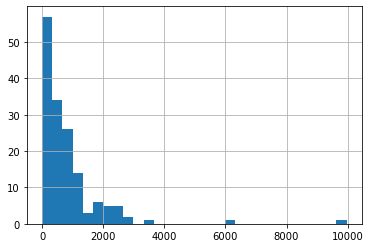

In [18]:
gdf_rome['n_shops'].hist(bins=30)

In [19]:
# there are two areas with very high number of shops

import numpy as np
gdf_rome[gdf_rome['n_shops'] >= np.quantile(gdf_rome['n_shops'], 0.99)]

,PRO_COM,COD_Z_URB,DEN_Z_URB,SHAPE_Leng,SHAPE_Area,geometry,n_traffic_lights,density_traffic_lights,n_shops
75,58091.0,1A,Centro Storico,9484.910322,3.204813e+06,"POLYGON ((788706.537 4645927.869, 788707.901 4...",41.0,12.793257,9965
79,58091.0,1E,Esquilino,8749.226658,3.092370e+06,"POLYGON ((789967.916 4644938.127, 789980.692 4...",43.0,13.905194,6124


In [20]:
# NaNs are areas where there are zero shops
gdf_rome['n_shops'] = gdf_rome['n_shops'].fillna(0)

# compute shops density for each area:
gdf_rome['density_shops'] = gdf_rome['n_shops'] / (gdf_rome['SHAPE_Area']*1e-6)

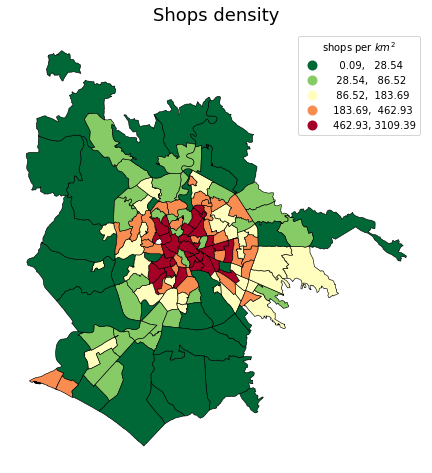

In [21]:
fig, ax = plt.subplots(1, figsize=(8,8))
gdf_rome.plot(ax=ax, column='density_shops', cmap='RdYlGn_r', edgecolor='black', linewidth=0.6,
              legend=True, legend_kwds={'title': r"shops per $km^2$"}, scheme='quantiles')


ax.set_title('Shops density', fontsize=18, pad=10)
ax.set_axis_off()

#fig = ax.get_figure()
#fig.savefig('rome_shop_density.png', dpi=300)

In [22]:
gdf_rome.head()

,PRO_COM,COD_Z_URB,DEN_Z_URB,SHAPE_Leng,SHAPE_Area,geometry,n_traffic_lights,density_traffic_lights,n_shops,density_shops
0,58091.0,10L,Morena,22732.760455,8.947226e+06,"POLYGON ((799657.107 4638085.920, 800364.229 4...",10.0,1.117665,960,107.295822
1,58091.0,10A,Don Bosco,8400.069997,2.256348e+06,"POLYGON ((794872.968 4641012.637, 794889.887 4...",17.0,7.534299,1854,821.681815
2,58091.0,10B,Appio-Claudio,9265.317994,3.454590e+06,"POLYGON ((794285.305 4640821.527, 794303.261 4...",16.0,4.631520,1236,357.784910
3,58091.0,10C,Quarto Miglio,11017.098179,5.030157e+06,"POLYGON ((796561.107 4637688.499, 796576.519 4...",9.0,1.789208,738,146.715093
4,58091.0,10D,Pignatelli,5161.962256,9.972986e+05,"POLYGON ((794842.436 4638845.513, 794843.764 4...",2.0,2.005417,178,178.482157


### Network features
The considered features are:
- network density
- edges’ betweenness centrality
- ratio of motorway roads

that can be computed from OpenStreetMap's data.

Note: the city's entire road network has been previously downloaded and saved in ```../data/external/```.

In [23]:
import osmnx as ox
import networkx as nx

PATH_TO_ROAD_NETWORK = '../data/external/rome_drive_service_network.graphml'

In [24]:
# Reprojecting the geodataframe with areas' geometries...
gdf_rome_4326 = gdf_rome.to_crs('epsg:4326')

In [25]:
## Getting the graph of the entire city of Rome (previously saved in ../data/external/)
G = ox.load_graphml(filepath=PATH_TO_ROAD_NETWORK)

print('> Graph type: ', type(G))
print('> Num of edges: ', G.number_of_edges())
print('> Num of nodes: ', G.number_of_nodes())

> Graph type:  <class 'networkx.classes.multigraph.MultiGraph'>
> Num of edges:  87029
> Num of nodes:  64444


#### Street length (tot), street density, ratio of motorways, POIs

In [26]:
def get_POIs_in_polygon(polygon):
    """Get food, education and service POIs number in the given region.
    
    Parameters:
    -----------
    polygon : shapely.Polygon
        the polygon defining the region
    
    Returns:
    --------
    dict : a dictionary with POI category as key and number of POIs of that category found in the region.
    """
    
    ### POIs ###
    food_amenities = ['pub', 'bar', 'restaurant', 'cafe', 'food_court']  # https://wiki.openstreetmap.org/wiki/Key:amenity
    education_amenities = ['college', 'kindergarten', 'library', 'school', 'university']
    service_amenities = ['bank', 'clinic', 'hospital', 'pharmacy', 'marketplace', 'post_office']
    map__poi_type__poi = {'amenity': food_amenities + education_amenities + service_amenities}
    map__poi__poi_category = {'pub': 'food',
                              'bar': 'food',
                              'restaurant': 'food',
                              'cafe': 'food',
                              'food_court': 'food',
                              'college': 'education',
                              'kindergarten': 'education',
                              'library': 'education',
                              'school': 'education',
                              'university': 'education',
                              'bank': 'service',
                              'clinic': 'service',
                              'hospital': 'service',
                              'pharmacy': 'service',
                              'marketplace': 'service',
                              'post_office': 'service'}
    
    # querying all the POIs of certain types in the region
    gdf_pois = ox.geometries_from_polygon(polygon, map__poi_type__poi)
    
    # creating dictionary with categories of POIs and counts
    map__poi_cat__num_of_poi = {
        'food': 0,
        'education': 0,
        'service': 0
    }
    for poi_type, poi_list in map__poi_type__poi.items():
        if poi_type in gdf_pois.columns:
            c_df = getattr(gdf_pois, poi_type).value_counts()
            for poi in [poi for poi in c_df.index if poi in poi_list]:
                poi_category = map__poi__poi_category[poi]
                # if poi_category not in map__poi_cat__num_of_poi:
                #    map__poi_cat__num_of_poi[poi_category] = 0
                map__poi_cat__num_of_poi[poi_category] += c_df[poi]
    
    return map__poi_cat__num_of_poi

In [30]:
%%time

from osmnx.stats import street_length_total

list_street_length_tot = []
list_street_density = []
list_motorway_ratio = []
list_n_food = []
list_food_density = []
list_n_education = []
list_education_density = []
list_n_service = []
list_service_density = []
list_n_all_POIs = []
list_all_POIs_density = []
i = 0
for c_zone, c_zone_name, c_zone_area in zip(gdf_rome_4326['geometry'], gdf_rome_4326['DEN_Z_URB'], gdf_rome_4326['SHAPE_Area']):
    try:
        # try to take the subgraph describing the road network of the zurrent zone
        G_sub = ox.truncate.truncate_graph_polygon(G, c_zone, retain_all=True)
    except ValueError:
        # this exception is for one zone ('Martignano') which is not urban
        list_street_length_tot.append(0)
        list_street_density.append(0)
        list_motorway_ratio.append(0)
        list_n_food.append(0)
        list_food_density.append(0)
        list_n_education.append(0)
        list_education_density.append(0)
        list_n_service.append(0)
        list_service_density.append(0)
        list_n_all_POIs.append(0)
        list_all_POIs_density.append(0)
        continue
    '''
    c_stats = ox.stats.basic_stats(G_sub, area=c_zone_area)  # returns a dictionary with network statistics
    c_street_length_tot = c_stats['street_length_total']
    c_street_density = c_stats['street_density_km']
    c_street_per_node_avg = c_stats['streets_per_node_avg']
    '''
    
    c_zone_area_km = c_zone_area / 1000000
    
    # street length tot
    c_street_length_tot = street_length_total(G_sub)
    c_street_length_tot_km = c_street_length_tot / 1000
    list_street_length_tot.append(c_street_length_tot)
    
    # street density (km of roads per km^2)
    c_street_density = c_street_length_tot_km / c_zone_area_km
    list_street_density.append(c_street_density)
    
    # ratio of roads of type "motorway"
    dict_road_to_type = nx.get_edge_attributes(G_sub, 'highway')
    n_motorways = len([road_type for road_type in dict_road_to_type.values() if road_type == 'motorway'])
    c_motorway_ratio = n_motorways / len(dict_road_to_type.keys()) * 100
    list_motorway_ratio.append(c_motorway_ratio)

    ### POIs
    dict_POIs = get_POIs_in_polygon(c_zone)
    # food amenities
    n_food = dict_POIs['food']
    c_food_density = n_food / c_zone_area_km
    list_n_food.append(n_food)
    list_food_density.append(c_food_density)
    # education amenities
    n_education = dict_POIs['education']
    c_education_density = n_education / c_zone_area_km
    list_n_education.append(n_education)
    list_education_density.append(c_education_density)
    # service amenities
    n_service = dict_POIs['service']
    c_service_density = n_service / c_zone_area_km
    list_n_service.append(n_service)
    list_service_density.append(c_service_density)
    # ALL amenities (food+education+service)
    n_all = n_food + n_education + n_service
    c_all_density = n_all / c_zone_area_km
    list_n_all_POIs.append(n_all)
    list_all_POIs_density.append(c_all_density)
    
    #
    i+=1
    print('processed: %s (%s)' %(i, c_zone_name))
    #

## adding the new columns
gdf_rome['street_len_tot'] = list_street_length_tot
gdf_rome['street_density'] = list_street_density
gdf_rome['motorway_ratio'] = list_motorway_ratio
gdf_rome['n_food_amenities'] = list_n_food
gdf_rome['density_food_amenities'] = list_food_density
gdf_rome['n_education_amenities'] = list_n_education
gdf_rome['density_education_amenities'] = list_education_density
gdf_rome['n_service_amenities'] = list_n_service
gdf_rome['density_service_amenities'] = list_service_density
gdf_rome['n_all_amenities'] = list_n_all_POIs
gdf_rome['density_all_amenities'] = list_all_POIs_density

print('')
print(gdf_rome.head())
print('')

processed: 1 (Morena)
processed: 2 (Don Bosco)
processed: 3 (Appio-Claudio)
processed: 4 (Quarto Miglio)
processed: 5 (Pignatelli)
processed: 6 (Lucrezia Romana)
processed: 7 (Osteria del Curato)
processed: 8 (Romanina)
processed: 9 (Gregna)
processed: 10 (Barcaccia)
processed: 11 (Appia Antica Sud)
processed: 12 (Marconi)
processed: 13 (Eur)
processed: 14 (Villaggio Giuliano)
processed: 15 (Torrino)
processed: 16 (Laurentino)
processed: 17 (Ciampino)
processed: 18 (Ostiense)
processed: 19 (Valco S. Paolo)
processed: 20 (Garbatella)
processed: 21 (Navigatori)
processed: 22 (Tormarancia)
processed: 23 (Tre Fontane)
processed: 24 (Grottaperfetta)
processed: 25 (Appia Antica Nord)
processed: 26 (Porta Medaglia)
processed: 27 (Cecchignola)
processed: 28 (Mezzocammino)
processed: 29 (Spinaceto)
processed: 30 (Vallerano Castel di Leva)
processed: 31 (Decima)
processed: 32 (Acilia Nord)
processed: 33 (Acilia Sud)
processed: 34 (Palocco)
processed: 35 (Ostia Antica)
processed: 36 (Ostia Nord)


In [29]:
### TEST ###

from osmnx.stats import street_length_total

list_street_length_tot = []
list_street_density = []
list_street_per_node_avg = []

c_zone = gdf_rome_4326.loc[10, 'geometry']
c_zone_name = gdf_rome_4326.loc[10, 'DEN_Z_URB']
c_zone_area = gdf_rome_4326.loc[10, 'SHAPE_Area'] 
c_zone_area_km = c_zone_area / 1000000

print(c_zone_name)
G_sub = ox.truncate.truncate_graph_polygon(G, c_zone, retain_all=True)

#c_stats = ox.stats.basic_stats(G_sub, area=c_zone_area)  # returns a dictionary with network statistics
#c_street_length_tot = c_stats['street_length_total']
c_street_length_tot = street_length_total(G_sub)
c_street_length_tot_km = c_street_length_tot / 1000
#c_street_density = c_stats['street_density_km']
c_street_density = c_street_length_tot_km / c_zone_area_km
#c_street_per_node_avg = c_stats['streets_per_node_avg']

list_street_length_tot.append(c_street_length_tot)
list_street_density.append(c_street_density)
#list_street_per_node_avg.append(c_street_per_node_avg)

dict_road_to_type = nx.get_edge_attributes(G_sub, 'highway')
n_motorways = len([road_type for road_type in dict_road_to_type.values() if road_type == 'motorway'])
motorway_ratio = n_motorways / len(dict_road_to_type.keys()) * 100

# POIs
dict_POIs = get_POIs_in_polygon(c_zone)
n_food = dict_POIs['food']
c_food_density = n_food / c_zone_area_km
n_education = dict_POIs['education']
c_education_density = n_education / c_zone_area_km
n_service = dict_POIs['service']
c_service_density = n_service / c_zone_area_km
n_all = n_food + n_education + n_service
c_all_density = n_all / c_zone_area_km

print(c_street_length_tot_km)
print(c_street_density)
print(motorway_ratio)
print('POIs:')
print('N. food amenities: %s (density: %s)' %(n_food,c_food_density))
print('N. education amenities: %s (density: %s)' %(n_education,c_education_density))
print('N. service amenities: %s (density: %s)' %(n_service,c_service_density))
print('N. ALL amenities: %s (density: %s)' %(n_all,c_all_density))

Appia Antica Sud
25.386219
2.386653380025262
4.2105263157894735
POIs:
N. food amenities: 1 (density: 0.09401373950273027)
N. education amenities: 0 (density: 0.0)
N. service amenities: 0 (density: 0.0)
N. ALL amenities: 1 (density: 0.09401373950273027)


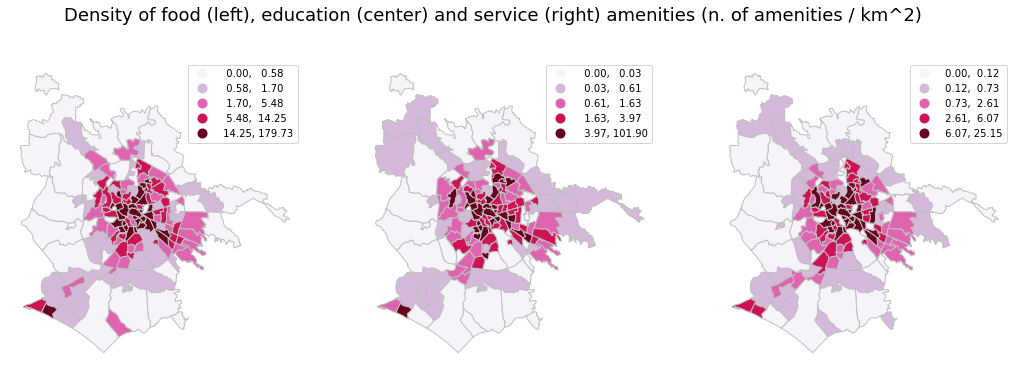

In [70]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

for ax, col in zip(axs, ['density_food_amenities', 'density_education_amenities', 'density_service_amenities']):
    gdf_rome_pt.plot(column=col,  ax=ax,
                          #figsize=(10,10), 
                          cmap='PuRd', edgecolor='silver',
                          scheme='Quantiles', k=5, 
                          #missing_kwds={'color': 'lightgrey'}, 
                          legend=True)
    #ax.set_title('Density of food, education and service amenities (n. of amenities / km^2)', fontsize=16, pad=10)
    ax.set_axis_off()
    
fig.suptitle('Density of food (left), education (center) and service (right) amenities (n. of amenities / km^2)', fontsize=18)
plt.show()
#fig = ax.get_figure()
#fig.savefig('rome_accessibility_public_transport.png', dpi=300)

#### Edges' betweenness centrality

The edges' betweenness centrality has been computed remotely on the entire network of the city, and stored as a new attribute on the edges of the city's network.

We consider here as a statistic for each urban zone *the number of roads whose betweenness centrality* (previously computed w.r.t. the entire city's network) *is greater than a certain threshold $p_{95}$*. This threshold is the 95th percentile of the distribution of the betweenness centrality of all the roads in the city's network.

In [31]:
## The betweenness centrality attribute on the edges of the network is a string. The following code converts it to float...
map__edge__bcentrality_as_float = {edge: float(val) for edge,val in nx.get_edge_attributes(G, 'betweenness_centrality').items()}
nx.set_edge_attributes(G, map__edge__bcentrality_as_float, 'betweenness_centrality')

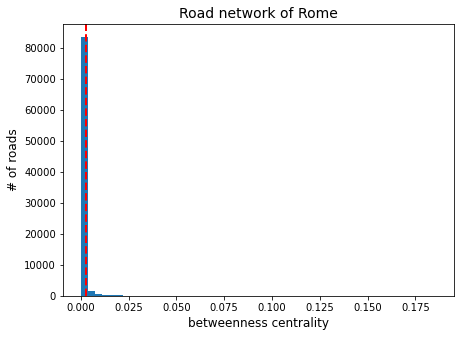

In [32]:
## distribution of the betweenness centrality of all the roads in the city

list_bc_entire_city = list(nx.get_edge_attributes(G, 'betweenness_centrality').values())
p_95 = np.percentile(list_bc_entire_city, 95) ## 95th percentile of the distribution

fig, ax = plt.subplots(figsize=(7,5))
plt.hist(list_bc_entire_city, bins=50)
plt.xlabel('betweenness centrality', fontsize=12)
plt.ylabel('# of roads', fontsize=12)
plt.title('Road network of Rome', fontsize=14)
plt.axvline(p_95, linestyle='--', linewidth=2, color='red')
plt.show()

Let's see an example of one single zone...

In [59]:
## selecting the subgraph of a single area:

example_geometry = gdf_rome_4326.iloc[0]['geometry']

G_sub = ox.truncate.truncate_graph_polygon(G, example_geometry, retain_all=True)

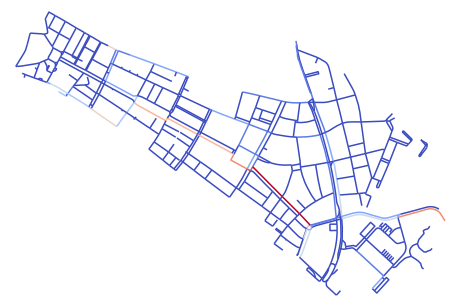

In [39]:
# get a color for each edge, by centrality, then plot the network with colored edges
ec = ox.plot.get_edge_colors_by_attr(G_sub, 'betweenness_centrality', cmap='coolwarm', num_bins=10, equal_size=False)
fig, ax = ox.plot_graph(G_sub, bgcolor='w', edge_color=ec, edge_linewidth=1.5, node_size=0)

In [62]:
list_bc_current_zone = list(nx.get_edge_attributes(G_sub, 'betweenness_centrality').values())
list_bc_current_zone_greater_than_p95 = [bc for bc in list_bc_current_zone if bc >= p_95]
perc_road_with_bc_grater_than_p95 = len(list_bc_current_zone_greater_than_p95)/len(list_bc_current_zone)*100
print('Num. of roads with betweenness centrality >= p_95: %s (%.2f%% of the roads in the zone)' %(len(list_bc_current_zone_greater_than_p95), perc_road_with_bc_grater_than_p95))

Num. of roads with betweenness centrality >= p_95: 22 (2.45% of the roads in the zone)


In the following, we compute the betweenness centrality statistic for all the 155 urban zones.

The results are saved in ```../data/processed/Roma_Zone_Urbanistiche__with_betweenness_centrality.shp```.

In [ ]:
### code for computing the statistic on betweenness centrality for all the 155 zones
## this takes time --> go directly to the cell below to load the results

list_bc_greater_than_p95 = []
for c_zone, c_zone_name in zip(gdf_rome['geometry'], gdf_rome['DEN_Z_URB']):
    print(c_zone_name)
    try:
        # try to take the subgraph describing the road network of the zurrent zone
        G_sub = ox.truncate.truncate_graph_polygon(G, c_zone, retain_all=True)
    except ValueError:
        # this exception is for one zone ('Martignano') which is not urban
        list_bc_greater_than_p95.append(np.nan)
        continue
    list_bc_current_zone = list(nx.get_edge_attributes(G_sub, 'betweenness_centrality').values())
    list_bc_current_zone_greater_than_p95 = [bc for bc in list_bc_current_zone if bc >= p_95]
    perc_road_with_bc_grater_than_p95 = len(list_bc_current_zone_greater_than_p95)/len(list_bc_current_zone)*100
    list_bc_greater_than_p95.append(perc_road_with_bc_grater_than_p95)

###

In [33]:
## as the process for computing the betweenness centrality statistic for each area takes some time, 
## we load here a shapefile where we saved the results:

PATH_TO_DATA = '../data/processed/'

gdf_rome_with_betweenness_centrality = gpd.read_file(PATH_TO_DATA + 'Roma_Zone_Urbanistiche__with_betweenness_centrality.shp')
print(gdf_rome_with_betweenness_centrality.shape)
print(gdf_rome_with_betweenness_centrality.crs)
gdf_rome_with_betweenness_centrality.head()

(155, 7)
epsg:32632


,PRO_COM,COD_Z_URB,DEN_Z_URB,SHAPE_Leng,SHAPE_Area,%_roads_bc,geometry
0,58091.0,10L,Morena,22732.760455,8.947226e+06,2.447164,"POLYGON ((799657.107 4638085.920, 800364.229 4..."
1,58091.0,10A,Don Bosco,8400.069997,2.256348e+06,2.533784,"POLYGON ((794872.968 4641012.637, 794889.887 4..."
2,58091.0,10B,Appio-Claudio,9265.317994,3.454590e+06,1.465201,"POLYGON ((794285.305 4640821.527, 794303.261 4..."
3,58091.0,10C,Quarto Miglio,11017.098179,5.030157e+06,6.109980,"POLYGON ((796561.107 4637688.499, 796576.519 4..."
4,58091.0,10D,Pignatelli,5161.962256,9.972986e+05,0.000000,"POLYGON ((794842.436 4638845.513, 794843.764 4..."


In [34]:
## updating the gdf_rome with the new column

gdf_rome['perc_roads_bc'] = gdf_rome_with_betweenness_centrality['%_roads_bc']
gdf_rome.head()

,PRO_COM,COD_Z_URB,DEN_Z_URB,SHAPE_Leng,SHAPE_Area,geometry,n_traffic_lights,density_traffic_lights,n_shops,density_shops,...,motorway_ratio,n_food_amenities,density_food_amenities,n_education_amenities,density_education_amenities,n_service_amenities,density_service_amenities,n_all_amenities,density_all_amenities,perc_roads_bc
0,58091.0,10L,Morena,22732.760455,8.947226e+06,"POLYGON ((799657.107 4638085.920, 800364.229 4...",10.0,1.117665,960,107.295822,...,0.000000,31,3.464761,8,0.894132,9,1.005898,48,5.364791,2.447164
1,58091.0,10A,Don Bosco,8400.069997,2.256348e+06,"POLYGON ((794872.968 4641012.637, 794889.887 4...",17.0,7.534299,1854,821.681815,...,0.000000,79,35.012332,18,7.977493,35,15.511793,132,58.501618,2.533784
2,58091.0,10B,Appio-Claudio,9265.317994,3.454590e+06,"POLYGON ((794285.305 4640821.527, 794303.261 4...",16.0,4.631520,1236,357.784910,...,0.000000,79,22.868129,12,3.473640,21,6.078870,112,32.420639,1.465201
3,58091.0,10C,Quarto Miglio,11017.098179,5.030157e+06,"POLYGON ((796561.107 4637688.499, 796576.519 4...",9.0,1.789208,738,146.715093,...,0.203666,15,2.982014,3,0.596403,8,1.590408,26,5.168824,6.109980
4,58091.0,10D,Pignatelli,5161.962256,9.972986e+05,"POLYGON ((794842.436 4638845.513, 794843.764 4...",2.0,2.005417,178,178.482157,...,0.000000,7,7.018961,2,2.005417,4,4.010835,13,13.035214,0.000000


### Mapparoma's features
These features are the ones we get directly from the [#mapparoma project's open data](https://www.mapparoma.info/contatti/), like
- public transport accessibility
- number of car accidents
- population density

#### Car accidents

Mapparoma's dataset #23

In [35]:
URL_TO_DATA = 'https://docs.google.com/spreadsheets/d/1PmAuSnuts2lvqJVqhNmmv0QKffnGa1S0/edit#gid=1605493318'

df_acc = pd.read_csv(URL_TO_DATA.replace('/edit#gid=', '/export?format=csv&gid='), 
                     header=1, 
                     #dtype = {'Incidenti' : int}, 
                     na_values = '  -   ',
                     #decimal = ',',
                     nrows=156  # added to avoid reading also the end of file with license
                    )
print(df_acc.shape)
df_acc.head()

(156, 13)


,Cod.,Nome,Municipio,Residenziale,Entro GRA,Incidenti,Morti,Feriti,Illesi,Incidenti in bici,Coinvolti in bici,Feriti in bici,Morti ogni 100 incidenti
0,1A,Centro Storico,1.0,1.0,1.0,532.0,NaN,232.0,984.000,6.0,13.0,4.0,NaN
1,1B,Trastevere,1.0,1.0,1.0,226.0,1.0,112.0,459.000,2.0,4.0,3.0,"0,44"
2,1C,Aventino,1.0,1.0,1.0,228.0,1.0,124.0,443.000,NaN,NaN,NaN,"0,44"
3,1D,Testaccio,1.0,1.0,1.0,77.0,NaN,31.0,133.000,1.0,2.0,1.0,NaN
4,1E,Esquilino,1.0,1.0,1.0,663.0,2.0,371.0,1.242,4.0,5.0,3.0,"0,30"


In [36]:
### JOIN

gdf_rome_acc = gdf_rome.merge(df_acc, how='left', left_on='COD_Z_URB', right_on='Cod.')

In [37]:
import mapclassify

q8 = mapclassify.Quantiles(gdf_rome_acc['Incidenti'], k=5)
q8

Quantiles               

    Interval       Count
------------------------
[   nan,  66.80] |    62
( 66.80, 120.80] |    31
(120.80, 182.00] |    32
(182.00, 287.40] |    30
(287.40,    nan] |     0

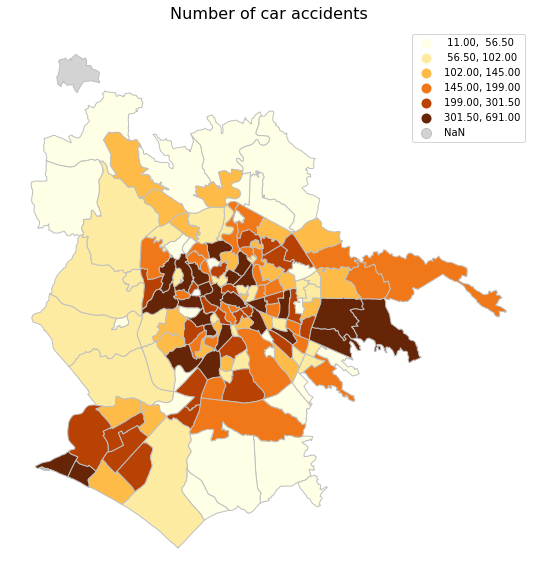

In [38]:
ax = gdf_rome_acc.plot(column='Incidenti', 
                         figsize=(10,10), cmap='YlOrBr', edgecolor='silver',
                          scheme='Quantiles', k=6, 
                          missing_kwds={'color': 'lightgrey'}, 
                          legend=True)
ax.set_title('Number of car accidents', fontsize=16, pad=10)
ax.set_axis_off()
#fig = ax.get_figure()
#fig.savefig('rome_accessibility_public_transport.png', dpi=300)

In [39]:
## updating the gdf_rome with the new column

gdf_rome['car_accidents'] = gdf_rome_acc['Incidenti']
gdf_rome.head()

,PRO_COM,COD_Z_URB,DEN_Z_URB,SHAPE_Leng,SHAPE_Area,geometry,n_traffic_lights,density_traffic_lights,n_shops,density_shops,...,n_food_amenities,density_food_amenities,n_education_amenities,density_education_amenities,n_service_amenities,density_service_amenities,n_all_amenities,density_all_amenities,perc_roads_bc,car_accidents
0,58091.0,10L,Morena,22732.760455,8.947226e+06,"POLYGON ((799657.107 4638085.920, 800364.229 4...",10.0,1.117665,960,107.295822,...,31,3.464761,8,0.894132,9,1.005898,48,5.364791,2.447164,182.0
1,58091.0,10A,Don Bosco,8400.069997,2.256348e+06,"POLYGON ((794872.968 4641012.637, 794889.887 4...",17.0,7.534299,1854,821.681815,...,79,35.012332,18,7.977493,35,15.511793,132,58.501618,2.533784,367.0
2,58091.0,10B,Appio-Claudio,9265.317994,3.454590e+06,"POLYGON ((794285.305 4640821.527, 794303.261 4...",16.0,4.631520,1236,357.784910,...,79,22.868129,12,3.473640,21,6.078870,112,32.420639,1.465201,239.0
3,58091.0,10C,Quarto Miglio,11017.098179,5.030157e+06,"POLYGON ((796561.107 4637688.499, 796576.519 4...",9.0,1.789208,738,146.715093,...,15,2.982014,3,0.596403,8,1.590408,26,5.168824,6.109980,144.0
4,58091.0,10D,Pignatelli,5161.962256,9.972986e+05,"POLYGON ((794842.436 4638845.513, 794843.764 4...",2.0,2.005417,178,178.482157,...,7,7.018961,2,2.005417,4,4.010835,13,13.035214,0.000000,50.0


#### Public transport

Share of inhabitants living more than 10 minutes from a metro or tram station (Mapparoma's dataset #10).

In [40]:
URL_TO_DATA = 'https://docs.google.com/spreadsheets/d/1VEEvpHuMxg96-LU3zZgS_xYkMM7NmU9X/edit#gid=703509510'

df_pt = pd.read_csv(URL_TO_DATA.replace('/edit#gid=', '/export?format=csv&gid='), 
                    header=1, 
                    na_values = '  -   ',
                    decimal = ',',
                    nrows=156  # added to avoid reading also the end of file with license
                    )
print(df_pt.shape)
df_pt.head()

(156, 10)


,Cod.,Nome,Municipio,Residenziale,Entro GRA,"N° di passaggi al giorno di bus e tram alle fermate (""stops"")","""Stops"" per minuto",Residenti al censimento 2011,Residenti entro 10 minuti a piedi da una fermata su ferro,% residenti entro 10 minuti a piedi da una fermata su ferro
0,1A,Centro Storico,1.0,1.0,1.0,137.525,96,21.080,8.920,42.3
1,1B,Trastevere,1.0,1.0,1.0,36.923,26,10.484,1.351,12.9
2,1C,Aventino,1.0,1.0,1.0,33.255,23,6.963,6.963,100.0
3,1D,Testaccio,1.0,1.0,1.0,16.697,12,7.610,6.308,82.9
4,1E,Esquilino,1.0,1.0,1.0,85.818,60,30.105,31.941,100.0


In [41]:
### JOIN

gdf_rome_pt = gdf_rome.merge(df_pt, how='left', left_on='COD_Z_URB', right_on='Cod.')

In [42]:
# NaNs are areas where there are no inhabitants living within 10 mins from a tram/metro station
gdf_rome_pt['% residenti entro 10 minuti a piedi da una fermata su ferro'] = gdf_rome_pt['% residenti entro 10 minuti a piedi da una fermata su ferro'].fillna(0)

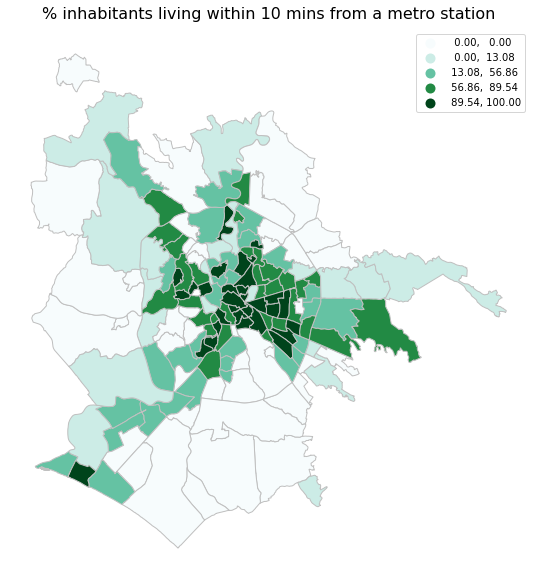

In [43]:
ax = gdf_rome_pt.plot(column='% residenti entro 10 minuti a piedi da una fermata su ferro', 
                         figsize=(10,10), cmap='BuGn', edgecolor='silver',
                          scheme='Quantiles', k=5, 
                          #missing_kwds={'color': 'lightgrey'}, 
                          legend=True)
ax.set_title('% inhabitants living within 10 mins from a metro station', fontsize=16, pad=10)
ax.set_axis_off()
#fig = ax.get_figure()
#fig.savefig('rome_accessibility_public_transport.png', dpi=300)

In [44]:
## updating the gdf_rome with the new column

gdf_rome['perc_people_far_from_public_transport'] = gdf_rome_pt['% residenti entro 10 minuti a piedi da una fermata su ferro']
gdf_rome.head()

,PRO_COM,COD_Z_URB,DEN_Z_URB,SHAPE_Leng,SHAPE_Area,geometry,n_traffic_lights,density_traffic_lights,n_shops,density_shops,...,density_food_amenities,n_education_amenities,density_education_amenities,n_service_amenities,density_service_amenities,n_all_amenities,density_all_amenities,perc_roads_bc,car_accidents,perc_people_far_from_public_transport
0,58091.0,10L,Morena,22732.760455,8.947226e+06,"POLYGON ((799657.107 4638085.920, 800364.229 4...",10.0,1.117665,960,107.295822,...,3.464761,8,0.894132,9,1.005898,48,5.364791,2.447164,182.0,2.8
1,58091.0,10A,Don Bosco,8400.069997,2.256348e+06,"POLYGON ((794872.968 4641012.637, 794889.887 4...",17.0,7.534299,1854,821.681815,...,35.012332,18,7.977493,35,15.511793,132,58.501618,2.533784,367.0,93.6
2,58091.0,10B,Appio-Claudio,9265.317994,3.454590e+06,"POLYGON ((794285.305 4640821.527, 794303.261 4...",16.0,4.631520,1236,357.784910,...,22.868129,12,3.473640,21,6.078870,112,32.420639,1.465201,239.0,99.8
3,58091.0,10C,Quarto Miglio,11017.098179,5.030157e+06,"POLYGON ((796561.107 4637688.499, 796576.519 4...",9.0,1.789208,738,146.715093,...,2.982014,3,0.596403,8,1.590408,26,5.168824,6.109980,144.0,35.1
4,58091.0,10D,Pignatelli,5161.962256,9.972986e+05,"POLYGON ((794842.436 4638845.513, 794843.764 4...",2.0,2.005417,178,178.482157,...,7.018961,2,2.005417,4,4.010835,13,13.035214,0.000000,50.0,0.0


#### Population density
Mapparoma's dataset #7.

In [45]:
URL_TO_DATA = 'https://docs.google.com/spreadsheets/d/1aEBBA_CVbLSxyFZDekq_vDrE9bdb42vC/edit#gid=2025467845'

df_pd = pd.read_csv(URL_TO_DATA.replace('/edit#gid=', '/export?format=csv&gid='), 
                    header=1, 
                    #dtype = {'Densità di popolazione 2018\n(ab. / ettaro)' : np.float64}, 
                    na_values = '  -   ',
                    decimal = ',',
                    nrows=157  # added to avoid reading also the end of file with license
                    )
print(df_pd.shape)
df_pd.head()

(157, 11)


,Cod.,Nome,Municipio,Residenziale,Entro GRA,Superficie (ettari),Residenti 2001,Residenti 2018,Densità di popolazione 2001\n(ab. / ettaro),Densità di popolazione 2018\n(ab. / ettaro),Variazione % dei residenti 2001-2018
0,1A,Centro Storico,1.0,1.0,1.0,319,32.291,25.077,"101,3","78,6","-22,3"
1,1B,Trastevere,1.0,1.0,1.0,181,16.111,14.204,"89,0","78,5","-11,8"
2,1C,Aventino,1.0,1.0,1.0,156,8.760,8.276,"56,1","53,0","-5,5"
3,1D,Testaccio,1.0,1.0,1.0,65,8.997,7.953,"138,8","122,7","-11,6"
4,1E,Esquilino,1.0,1.0,1.0,309,38.586,34.337,"124,7","111,0","-11,0"


In [46]:
df_pd.loc[df_pd['Densità di popolazione 2018\n(ab. / ettaro)'] == '0,0']

,Cod.,Nome,Municipio,Residenziale,Entro GRA,Superficie (ettari),Residenti 2001,Residenti 2018,Densità di popolazione 2001\n(ab. / ettaro),Densità di popolazione 2018\n(ab. / ettaro),Variazione % dei residenti 2001-2018
109,13X,Castel Porziano,10.0,0.0,0.0,6.149,142,144,"0,0","0,0","1,4"
153,20O,Martignano,15.0,0.0,0.0,1.081,25,48,"0,0","0,0","92,0"


In [47]:
### JOIN

gdf_rome_pd = gdf_rome.merge(df_pd, how='left', left_on='COD_Z_URB', right_on='Cod.')

In [48]:
gdf_rome_pd['Densità di popolazione 2018\n(ab. / ettaro)'] = gdf_rome_pd['Densità di popolazione 2018\n(ab. / ettaro)'].str.replace(',','.').astype(float)

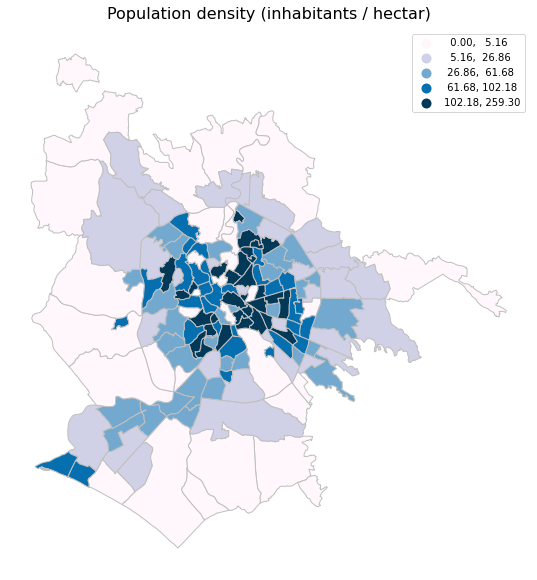

In [49]:
ax = gdf_rome_pd.plot(column='Densità di popolazione 2018\n(ab. / ettaro)', 
                         figsize=(10,10), cmap='PuBu', edgecolor='silver',
                          scheme='Quantiles', k=5, 
                          #missing_kwds={'color': 'lightgrey'}, 
                          legend=True)
ax.set_title('Population density (inhabitants / hectar)', fontsize=16, pad=10)
ax.set_axis_off()
#fig = ax.get_figure()
#fig.savefig('rome_accessibility_public_transport.png', dpi=300)

In [50]:
## updating the gdf_rome with the new column

gdf_rome['pop_density'] = gdf_rome_pd['Densità di popolazione 2018\n(ab. / ettaro)']
gdf_rome.head()

,PRO_COM,COD_Z_URB,DEN_Z_URB,SHAPE_Leng,SHAPE_Area,geometry,n_traffic_lights,density_traffic_lights,n_shops,density_shops,...,n_education_amenities,density_education_amenities,n_service_amenities,density_service_amenities,n_all_amenities,density_all_amenities,perc_roads_bc,car_accidents,perc_people_far_from_public_transport,pop_density
0,58091.0,10L,Morena,22732.760455,8.947226e+06,"POLYGON ((799657.107 4638085.920, 800364.229 4...",10.0,1.117665,960,107.295822,...,8,0.894132,9,1.005898,48,5.364791,2.447164,182.0,2.8,36.9
1,58091.0,10A,Don Bosco,8400.069997,2.256348e+06,"POLYGON ((794872.968 4641012.637, 794889.887 4...",17.0,7.534299,1854,821.681815,...,18,7.977493,35,15.511793,132,58.501618,2.533784,367.0,93.6,225.9
2,58091.0,10B,Appio-Claudio,9265.317994,3.454590e+06,"POLYGON ((794285.305 4640821.527, 794303.261 4...",16.0,4.631520,1236,357.784910,...,12,3.473640,21,6.078870,112,32.420639,1.465201,239.0,99.8,86.1
3,58091.0,10C,Quarto Miglio,11017.098179,5.030157e+06,"POLYGON ((796561.107 4637688.499, 796576.519 4...",9.0,1.789208,738,146.715093,...,3,0.596403,8,1.590408,26,5.168824,6.109980,144.0,35.1,21.7
4,58091.0,10D,Pignatelli,5161.962256,9.972986e+05,"POLYGON ((794842.436 4638845.513, 794843.764 4...",2.0,2.005417,178,178.482157,...,2,2.005417,4,4.010835,13,13.035214,0.000000,50.0,0.0,66.3


In [51]:
gdf_rome_pd.loc[gdf_rome_pd['Densità di popolazione 2018\n(ab. / ettaro)'] == 0]

,PRO_COM,COD_Z_URB,DEN_Z_URB,SHAPE_Leng,SHAPE_Area,geometry,n_traffic_lights,density_traffic_lights,n_shops,density_shops,...,Nome,Municipio,Residenziale,Entro GRA,Superficie (ettari),Residenti 2001,Residenti 2018,Densità di popolazione 2001\n(ab. / ettaro),Densità di popolazione 2018\n(ab. / ettaro),Variazione % dei residenti 2001-2018
44,58091.0,13X,Castel Porziano,39180.903326,6.153818e+07,"POLYGON ((783543.549 4631071.524, 783709.612 4...",2.0,0.0325,11,0.178751,...,Castel Porziano,10.0,0.0,0.0,6.149,142,144,"0,0",0.0,"1,4"
97,58091.0,20O,Martignano,17426.285886,1.085391e+07,"POLYGON ((773863.849 4670312.587, 773871.115 4...",0.0,0.0000,1,0.092133,...,Martignano,15.0,0.0,0.0,1.081,25,48,"0,0",0.0,"92,0"


In [52]:
len(set(df_pd['Cod.']).intersection(set(gdf_rome['COD_Z_URB'])))

155

In [57]:
### saving the GeoDataFrame as geojson

PATH_TO_PROCESSED_FILES = '../data/processed/'

gdf_rome.drop(columns=['PRO_COM'], inplace=True)
gdf_rome = gdf_rome.rename(columns={'COD_Z_URB': 'area_code', 'DEN_Z_URB':'area_name'})

gdf_rome.to_file(PATH_TO_PROCESSED_FILES + 'Rome_urban_zones_with_features__epsg32632.geojson', driver='GeoJSON')

In [58]:
# reprojecting the GeoDataFrame onto epsg:4326

PATH_TO_PROCESSED_FILES = '../data/processed/'

gdf_rome_32632 = gpd.read_file(PATH_TO_PROCESSED_FILES + 'Rome_urban_zones_with_features__epsg32632.geojson')
print(gdf_rome_32632.shape)
print(gdf_rome_32632.crs)
#gdf_rome.head()

gdf_rome_4326 = gdf_rome_32632.to_crs('epsg:4326')

gdf_rome_4326.to_file(PATH_TO_PROCESSED_FILES + 'Rome_urban_zones_with_features__epsg4326.geojson', driver='GeoJSON')

(155, 24)
epsg:32632
